# SInCohMap data access and processing examples
## boxcar filter (spatial convolution) vs multi-look (spatial average)
### Author michele.claus@eurac.edu
### Date: 2022/02/02

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## FAQ:
**Q: I receive a 403 error, what does it mean?**

A: If you get a 403 error, it usually means that the connection with the openEO back-end dropped. Please re run

`conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")`

and re run you code from `load_collection` onwards.

**Q: I receive a 500 error, what does it mean?**

A: It is a server error: something went wrong processing your request. Please check carefully that the area and time range you are requesting are available in the datacube (you can use `conn.describe_collection('COLLECTION_NAME')`) Currently the error logs are not passed if you run your request as a synchronous call (i.e. using `.download()`). If you run you process as a batch job you will get a more informative error message.

**Q: I receive a 502 error, what does it mean?**

A: If you get an error similar to: _[502] unknown: Received 502 Proxy Error. This typically happens if an OpenEO request takes too long and is killed. Consider using batch jobs instead of doing synchronous processing._
The message is already explaining you the problem: you are using a synchronous call (.download()) to run a process which is taking too much to complete. You need to use a batch job in this case.

If you already started a batch job, please try to list the jobs with:
`conn.list_jobs()`
and check if it's actually running of it has been stopped due to an error.

### Import all the libraries and utilities functions included in the eo_utils.py file

In [1]:
from eo_utils import *

### Connect and login

In [ ]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

Please check to have the latest openeo library. openeo >= 0.9.0 is required

In [ ]:
openeo.__version__

In [ ]:
conn.list_processes()

## Select the AOI
Use the rectangle selection tool to select the area of interest

In [ ]:
center = [37.2, -6.2]
zoom = 9

eoMap = openeoMap(center,zoom)
eoMap.map

In [ ]:
bbox = eoMap.getBbox()
print("Coordinates selected from map:",'\n west',bbox[0],'\n east',bbox[2],'\n south',bbox[1],'\n north',bbox[3])

In [ ]:
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}

In [ ]:
spatial_extent

## Doñana Datacubes:
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA
SAR2Cube_SInCohMap_S1_L0_154_DSC_DONYANA
```
Sentinel-2:
```
SInCohMap_S2_L1C_T29SQB
```
## South Tyrol Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL
SAR2Cube_SInCohMap_S1_L0_168_DSC_SOUTH_TYROL
```
Sentinel-2:
```
S2_L1C_T32TPS
```
## Finland Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI1
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI2
```

# SAR processing


### Load the datacube

In [ ]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'
temporal_extent = ["2017-01-02", "2017-01-03"]
bands = ['i_VV','q_VV','i_VH','q_VH','grid_lon','grid_lat']
S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent,bands=bands)

### Compute the intensity
We compute the intensity from the complex data

In [ ]:
i_VV = S1_slant_range.band('i_VV')
q_VV = S1_slant_range.band('q_VV')
S1_INT_VV = (i_VV**2+q_VV**2)
S1_INT_VV = S1_INT_VV.add_dimension(name="bands",label="VV")

i_VH = S1_slant_range.band('i_VH')
q_VH = S1_slant_range.band('q_VH')
S1_INT_VH = (i_VH**2+q_VH**2)
S1_INT_VH = S1_INT_VH.add_dimension(name="bands",label="VH")

S1_INT = S1_INT_VV.merge_cubes(S1_INT_VH)

### Apply a Boxcar filter
In openEO, a boxcar (uniform) filter can be applied using the `apply_kernel` process, which can apply the requested kernel to the data with a spatial convolution. More information about the process can be found here https://processes.openeo.org/#apply_kernel

First of all we need to construct the kernel

In [ ]:
range_dim   = 19
azimuth_dim = 4

kernel = np.ones((range_dim,azimuth_dim))

Call apply_kernel with the appropriate parameters: factor is set to 1/(range_dim*azimuth_dim) to rescale back the values after the convolution.

In [ ]:
S1_INT_boxcar_19x4 = S1_INT.apply_kernel(kernel=kernel,factor=1/(range_dim*azimuth_dim),border='reflect')

Convert from linear to dB

In [ ]:
S1_INT_dB = S1_INT_boxcar_19x4.apply(lambda x: 10*log(x,base=10))

Merge the result back with the lon/lat grids for geocoding

In [ ]:
lat_lon_grids = S1_slant_range.filter_bands(['grid_lon','grid_lat'])
S1_INT_dB_lon_lat = S1_INT_dB.merge_cubes(lat_lon_grids)

Geocode the result

In [ ]:
args_geocoding = {'resolution':10,'crs':32630}
S1_INT_dB_geocoded = S1_INT_dB_lon_lat.process("geocode",args_geocoding, data=S1_INT_dB_lon_lat)

Download the result as a geoTiff to check the geocoding

In [ ]:
S1_INT_dB_geocoded_netcdf = S1_INT_dB_geocoded.save_result(format='netCDF')

In [ ]:
job = conn.create_job(S1_INT_dB_geocoded_netcdf,title="Donyana_boxcar_19x4")
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

In [ ]:
conn.list_jobs()

In [ ]:
job = conn.job("5e8d4d3e-e2e3-40a5-b63f-ac77c0a0e0a6")
# job.delete_job()

Get the status of the job:

In [ ]:
job.describe_job()['status']

Once the job is marked as finished, you can download the result.

Either via the download link provided in the following visualization:

In [ ]:
result = job.get_results()
result

Or via python code specifying the target location:

In [ ]:
result.download_files("./boxcar_result/")

In [2]:
vv_vh_asc_boxcar = xr.open_dataarray("./boxcar_result/result.nc")
vv_vh_asc_boxcar

<xarray.DataArray 'stack-fda91556c62effd4c3cc8d013ab803af' (variable: 2, time: 1, y: 1013, x: 1406)>
[2848556 values with dtype=float64]
Coordinates:
  * y         (y) float32 4.107e+06 4.107e+06 4.107e+06 ... 4.117e+06 4.117e+06
  * x         (x) float32 2.176e+05 2.176e+05 2.176e+05 ... 2.316e+05 2.316e+05
  * time      (time) datetime64[ns] 2017-01-02T23:59:59
  * variable  (variable) object 'VV' 'VH'

In [3]:
#compute size based on output aspect ratio:
x_size = len(vv_vh_asc_boxcar.x)
y_size = len(vv_vh_asc_boxcar.y)
aspect_ratio = x_size/y_size

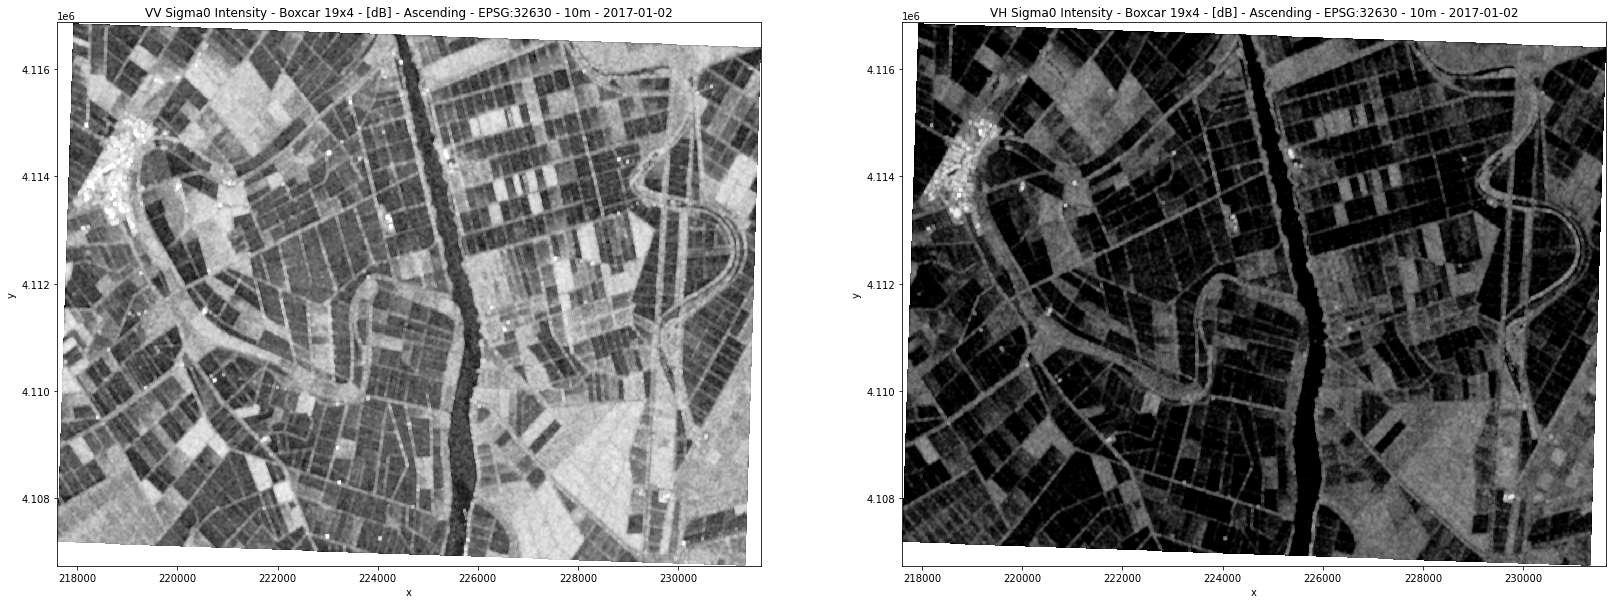

In [4]:
plot_args = {'cmap':'Greys_r','add_colorbar':False,'vmin':-30,'vmax':0}
fig, ax = plt.subplots(1,2,figsize=(2*10*aspect_ratio,10))
vv_vh_asc_boxcar.loc[{'variable':'VV'}][0].plot.imshow(ax=ax[0],**plot_args)
ax[0].set_title("VV Sigma0 Intensity - Boxcar 19x4 - [dB] - Ascending - EPSG:32630 - 10m - 2017-01-02")
vv_vh_asc_boxcar.loc[{'variable':'VH'}][0].plot.imshow(ax=ax[1],**plot_args)
ax[1].set_title("VH Sigma0 Intensity - Boxcar 19x4 - [dB] - Ascending - EPSG:32630 - 10m - 2017-01-02")
plt.show()


### Comparison with spatial multi-look (spatial window average)

We compute the intensity again for the same area, now using the spatial multi-look (openEO aggregate_spatial_window) instead of the boxcar filter (openEO apply_kernel)

In [ ]:
# Connect and authenticate to openEO
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

# Load the datacube
collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'
temporal_extent = ["2017-01-02", "2017-01-03"]
bands = ['i_VV','q_VV','i_VH','q_VH','grid_lon','grid_lat']
S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent,bands=bands)

# Compute the intensity for VV and VH
i_VV = S1_slant_range.band('i_VV')
q_VV = S1_slant_range.band('q_VV')
S1_INT_VV = (i_VV**2+q_VV**2)
S1_INT_VV = S1_INT_VV.add_dimension(name="bands",label="VV")

i_VH = S1_slant_range.band('i_VH')
q_VH = S1_slant_range.band('q_VH')
S1_INT_VH = (i_VH**2+q_VH**2)
S1_INT_VH = S1_INT_VH.add_dimension(name="bands",label="VH")

S1_INT = S1_INT_VV.merge_cubes(S1_INT_VH)

# Compute the Multi Look over the intensity and convert from linear to dB.
range_looks   = 19
azimuth_looks = 4

args_aggregate_spatial_window = {"data": THIS, "boundary": "trim", "size": [range_looks,azimuth_looks],"reducer":S1_INT._get_callback(mean,parent_parameters=["data"])}
S1_INT_ML = S1_INT.process("aggregate_spatial_window",args_aggregate_spatial_window)
S1_INT_ML_dB = S1_INT_ML.apply(lambda x: 10*log(x,base=10))

# Compute the same Multi Look over the coordinate grids for geocoding
lat_lon_grids = S1_slant_range.filter_bands(['grid_lon','grid_lat'])
args_aggregate_spatial_window = {"data": THIS, "boundary": "trim", "size": [range_looks,azimuth_looks],"reducer":lat_lon_grids._get_callback(mean,parent_parameters=["data"])}
lat_lon_grids_ML = lat_lon_grids.process("aggregate_spatial_window",args_aggregate_spatial_window)

# Merge the intensity and the coordinate grids into the same datacube
S1_INT_ML_dB = S1_INT_ML_dB.merge_cubes(lat_lon_grids_ML)

# Geocode the result
args_geocoding = {'resolution':10,'crs':32630}
S1_INT_ML_dB_geocoded = S1_INT_ML_dB.process("geocode",args_geocoding, data=S1_INT_ML_dB)

# Save the result as a netCDF
S1_INT_ML_dB_geocoded_netcdf = S1_INT_ML_dB_geocoded.save_result(format='netCDF')

In [ ]:
job = conn.create_job(S1_INT_ML_dB_geocoded_netcdf,title="Donyana_ML_19x4")
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

In [ ]:
conn.list_jobs()

You can delete a job doing:

In [ ]:
# job = conn.job("job_id")
# job.delete_job()

Get the status of the job:

In [ ]:
job.describe_job()['status']

Once the job is marked as finished, you can download the result

In [ ]:
result = job.get_results()
result.download_files("./ML_result/")

Boxcar vs Multi-Look visualization

In [5]:
vv_vh_asc_ml = xr.open_dataarray("./ML_result/result.nc")
vv_vh_asc_ml

<xarray.DataArray 'stack-e1137da6012662258a06e498bc0dfd4c' (variable: 2, time: 1, y: 1011, x: 1404)>
[2838888 values with dtype=float64]
Coordinates:
  * y         (y) float32 4.107e+06 4.107e+06 4.107e+06 ... 4.117e+06 4.117e+06
  * x         (x) float32 2.176e+05 2.176e+05 2.176e+05 ... 2.316e+05 2.316e+05
  * time      (time) datetime64[ns] 2017-01-02T23:59:59
  * variable  (variable) object 'VV' 'VH'

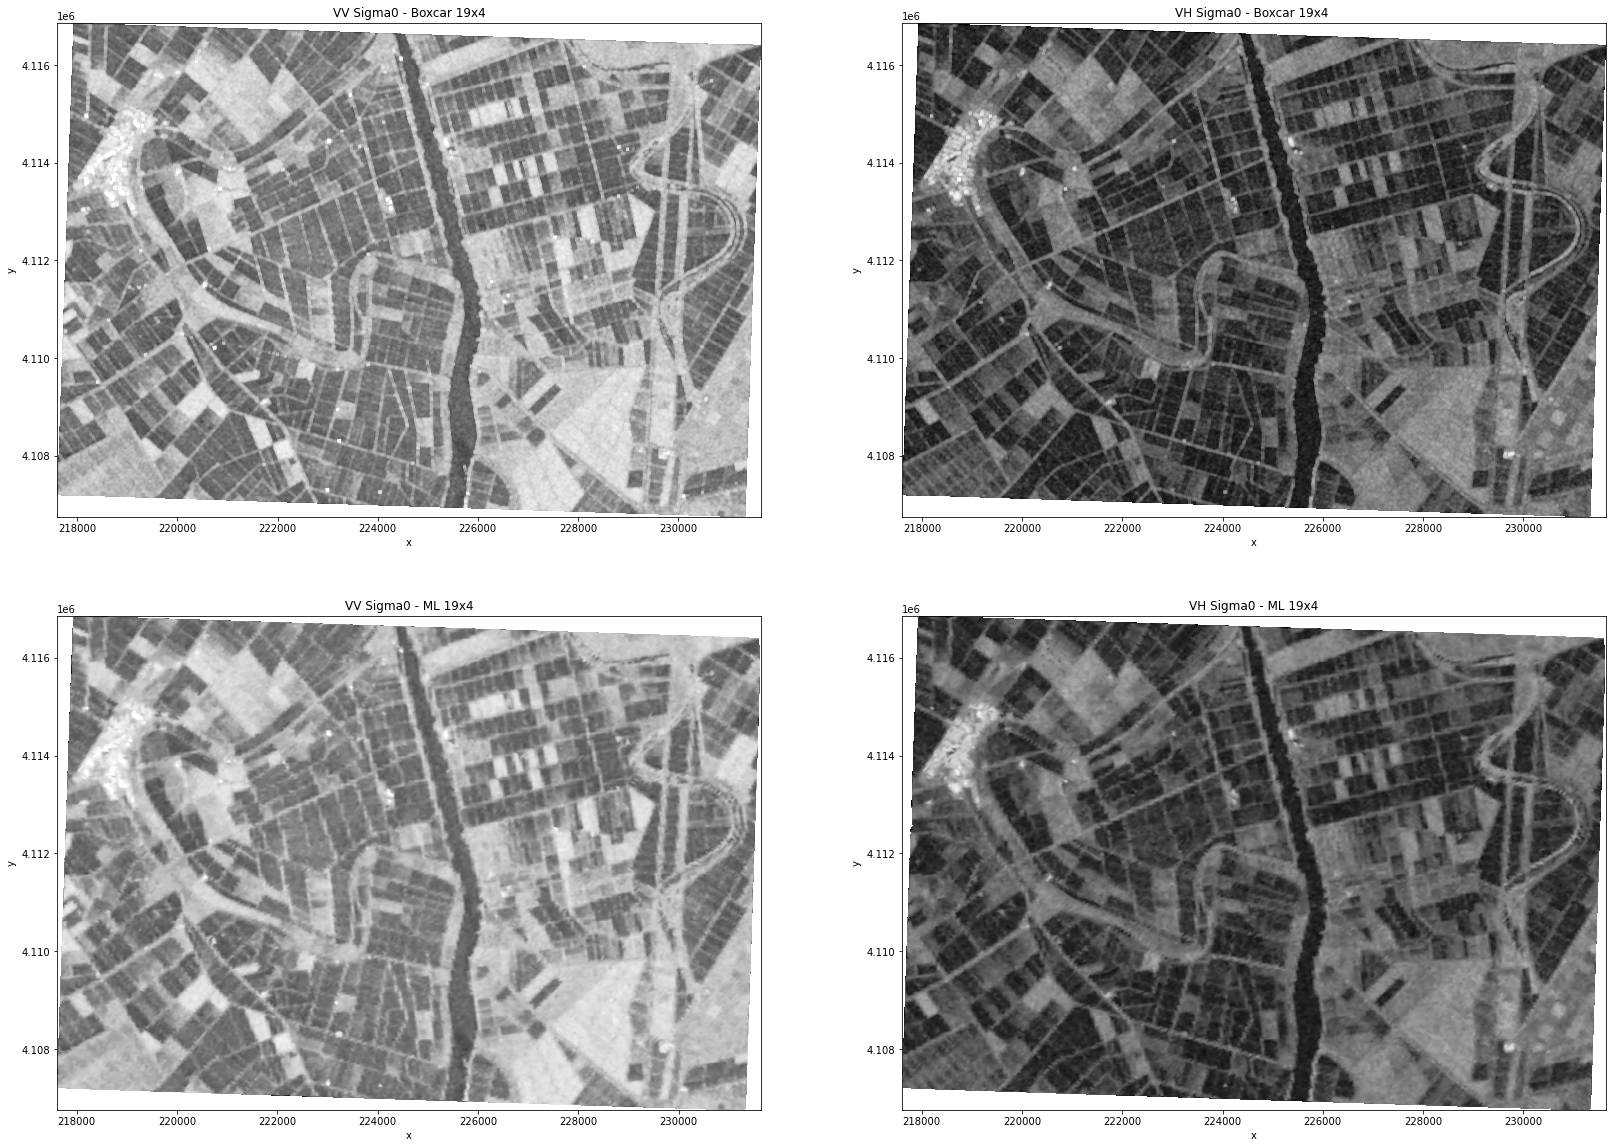

In [6]:
plot_args = {'cmap':'Greys_r','add_colorbar':False,'vmin':-35,'vmax':0}
fig, ax = plt.subplots(2,2,figsize=(20*aspect_ratio,20))
vv_vh_asc_boxcar.loc[{'variable':'VV'}][0].plot.imshow(ax=ax[0,0],**plot_args)
ax[0,0].set_title("VV Sigma0 - Boxcar 19x4")
vv_vh_asc_boxcar.loc[{'variable':'VH'}][0].plot.imshow(ax=ax[0,1],**plot_args)
ax[0,1].set_title("VH Sigma0 - Boxcar 19x4 ")
vv_vh_asc_ml.loc[{'variable':'VV'}][0].plot.imshow(ax=ax[1,0],**plot_args)
ax[1,0].set_title("VV Sigma0 - ML 19x4")
vv_vh_asc_ml.loc[{'variable':'VH'}][0].plot.imshow(ax=ax[1,1],**plot_args)
ax[1,1].set_title("VH Sigma0 - ML 19x4")
plt.show()